In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import pickle
from PIL import Image
import math
import random
import cv2 as cv
%matplotlib inline

# Meteo Webcam Analysis

The goal of this project is to analyze webcam capture images from [meteo.physic.ut.ee](https://meteo.physic.ut.ee/) and practice applying different analysis methods on the data. 
All images used here are downloaded from the [archive](https://meteo.physic.ut.ee/webcam/uus/archive/). Thank you to the Laboratory of Environmental Physics in University of Tartu (Institute of Physics) for keeping this archive open and free to use.

Ideas:
- Skies only (top 310 pixels).
- Cars in the parking lot.
- Weather, duration of days, light.
- People.
- Lights in the buildings.

Video clips of the archived footage can be found in the same location as the images, or in the form of a timelapse: [2019](https://youtu.be/q_ZRND_3uQY) and [2020](https://youtu.be/9cNdEs1fOOQ).

## Skies

Create a dataset of the sky only.

In [ ]:
def create_skies(resize_n, path_from, path_to):
    for month in os.listdir(path_from):
        for hour in os.listdir(path_from + month):
            img_arr = np.array(Image.open(path_from + month + '/' + hour))
            
            # Trim, keep the sky
            img_trimmed = img_arr[:310,:]
            
            # Resize by n (given as arg)
            img_resized = img_trimmed[::resize_n, ::resize_n]
            
            # Save image
            path = path_to + hour[:13] + '.jpg'
            plt.imsave(path, img_resized)
            

# The raw data folders included .jpg images from the webcam archive
for year in ['data/raw/2020/', 'data/raw/2019/']:
    create_skies(2, year, 'data_640/')

In [2]:
folder = 'data/256/' # Skies downscaled 5x
num_of_imgs = len(os.listdir(folder)[:1500]) # First 1500
width = 256
height = 62
channels = 3

data = np.ndarray(shape=(num_of_imgs, height, width, channels), dtype=np.uint8)
labels = np.ndarray(shape=(num_of_imgs), dtype=object)

data.shape, labels.shape

((1500, 62, 256, 3), (1500,))

In [3]:
# Load the images from disk (check RAM!)
for i,file in enumerate(os.listdir(folder)[:1500]): # First 1500
    img = Image.open(folder + file)
    data[i] = img
    labels[i] = file[5:-4].replace('-','').replace('T','')

1. 012714
2. 030211
3. 010402


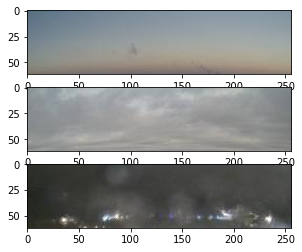

In [4]:
# Image preview
nums = [random.randint(0,1500) for i in range(3)]

_, ax = plt.subplots(len(nums), 1)
for i,num in enumerate(nums):
    print(f'{i+1}. {labels[num]}')
    ax[i].imshow(data[num])
    
plt.show()

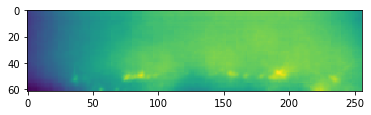

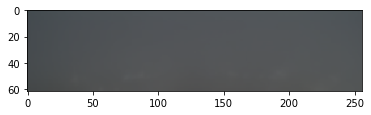

In [5]:
# Average of colors
plt.imshow(np.mean(data, axis=(0,3)))
plt.show()
plt.imshow(np.average(data, axis=0).astype(np.uint8))
plt.show()
# ...

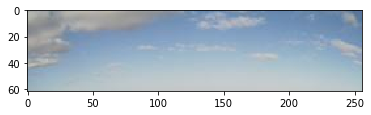

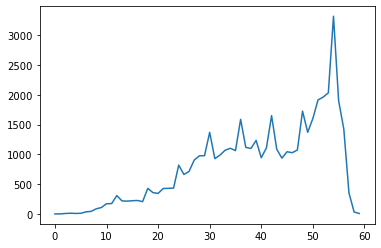

In [6]:
# Histogram of color values
num = 1332
hist, bin_edges = np.histogram(data[num], bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
plt.imshow(data[num])
plt.show()
plt.plot(hist)
plt.show()

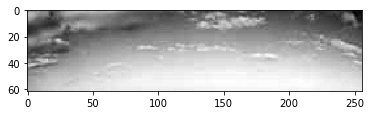

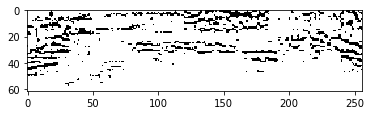

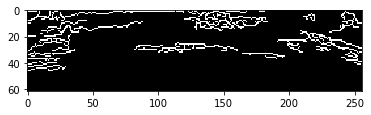

In [9]:
# Edge detection for clouds
gray = cv.cvtColor(data[num], cv.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = 'gray')
plt.show()

thresh = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 7, 2)
plt.imshow(thresh, cmap = 'gray')
plt.show()

edges = cv.Canny(gray, 20, 60)
plt.imshow(edges, cmap = 'gray')
plt.show()